# 🤒 Epidemic mitigation project

### Importing the relevant packages

In [1]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

### Loading the environment

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


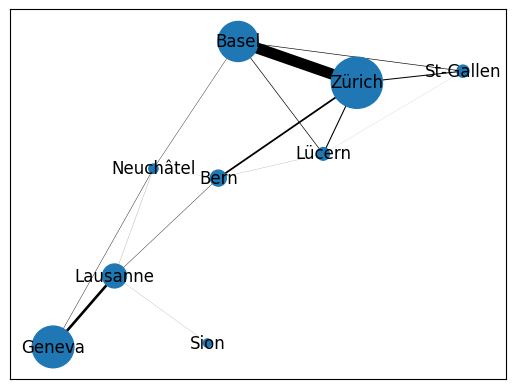

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities) # we added the encoding to ModelDynamics
dyn.draw_map()

sampled action : 3
Sampled observation


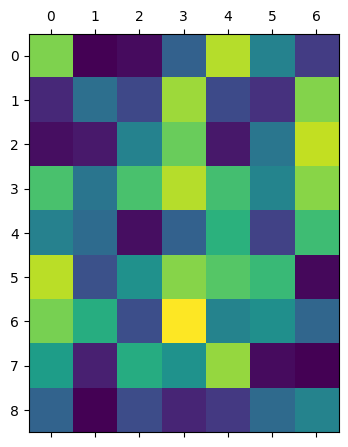

In [3]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[0,:,:])
plt.show()

In [4]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

### Question 1.a) study the behavior of the model when epidemics are unmitigated.

Running the epidemic simulation for one episode (30 weeks), without epidemic mitigation (meaning no action is
taken, i.e. all values in the action dictionary are set to False).

In [5]:
""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2)
while not finished:
    action = 0
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    
""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

#### Plots

<ipython-input-6-9d8e98dfd120>:7: RuntimeWarning: divide by zero encountered in log
  [ax_leftstate.plot(np.log(y)) for y in total.values()] # log-lin


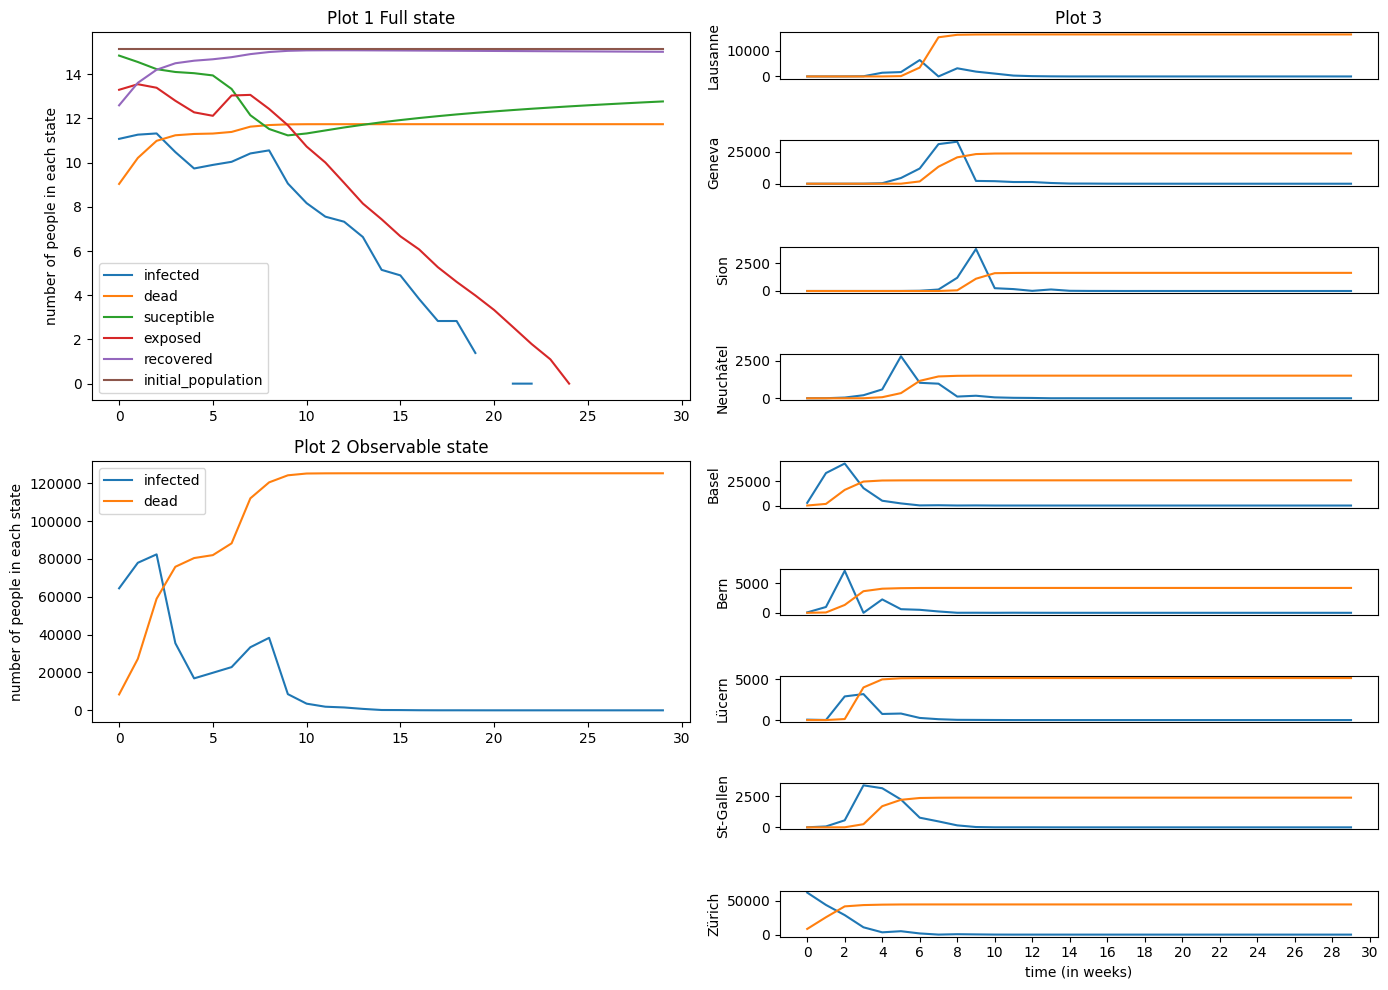

In [6]:
from matplotlib.ticker import MultipleLocator

def plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 3, 4]):
    fig = plt.figure(figsize=(14,10))
    if leftstate: 
        ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
        [ax_leftstate.plot(np.log(y)) for y in total.values()] # log-lin
        ax_leftstate.legend(total.keys())
        ax_leftstate.set_title(f'Plot {order[0]} Full state')
        ax_leftstate.set_ylabel('number of people in each state')
        
    if leftobs:
        ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
        [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
        ax_leftobs.legend(['infected','dead'])
        ax_leftobs.set_title(f'Plot {order[1]} Observable state')
        ax_leftobs.set_ylabel('number of people in each state')
    
    if leftactions:
        ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title(f'Plot {order[2]} Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')
                
    if right_per_city:
        ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
        ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
        ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}
        [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
        [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
        [ax.set_ylabel(c) for c, ax in ax_right.items()]
        [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
        ax_right['Zürich'].set_xlabel('time (in weeks)')
        ax_right['Lausanne'].set_title(f'Plot {order[3]}')
        ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()
    
plot_all(leftstate = True, leftobs =True, leftactions = False, right_per_city = True, order = [1, 2, 0, 3])

### Question 2.a) Implement Pr. Russo’s Policy

In [7]:
class RussoAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        self.count_confinement = 0
        self.dict = np.array([295000, 900000, 34978, 44531, 830000, 133115, 82000, 76213, 1354000])
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        total = np.sum(np.array(obs[0, 0, :, -1])*self.dict)/SCALE
        if total >= 20000:
            self.count_confinement = 1
            return 1
        if self.count_confinement == 4:
            self.count_confinement = 0
        if self.count_confinement != 0:
            self.count_confinement += 1
            return 1
        return 0

In [8]:
agent = RussoAgent(env)
log = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

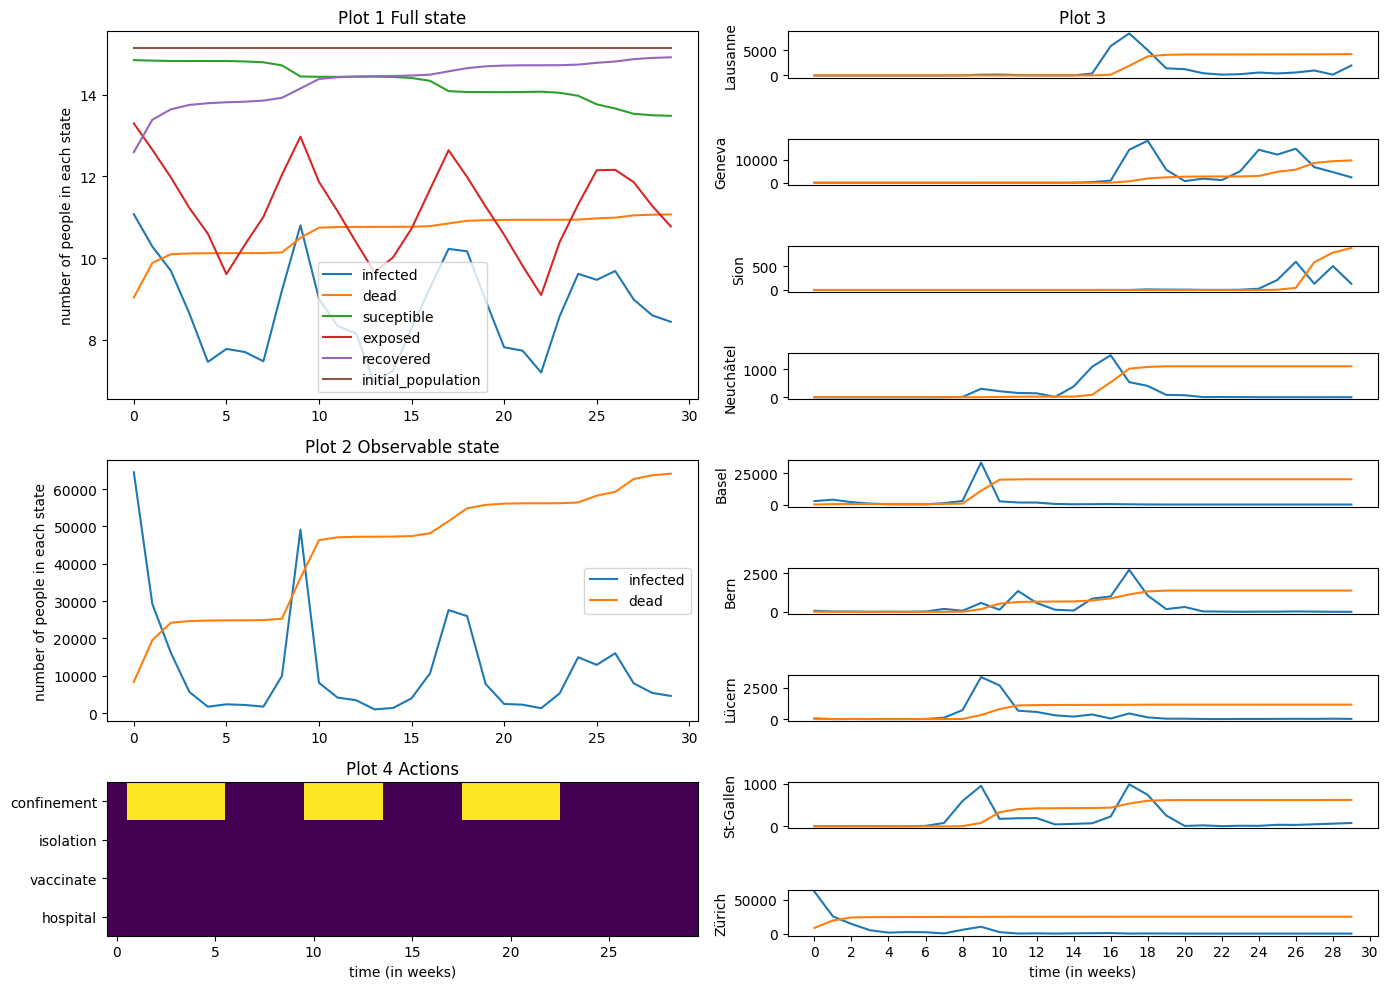

In [9]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

### Question 2.b) Evaluate Pr. Russo’s Policy

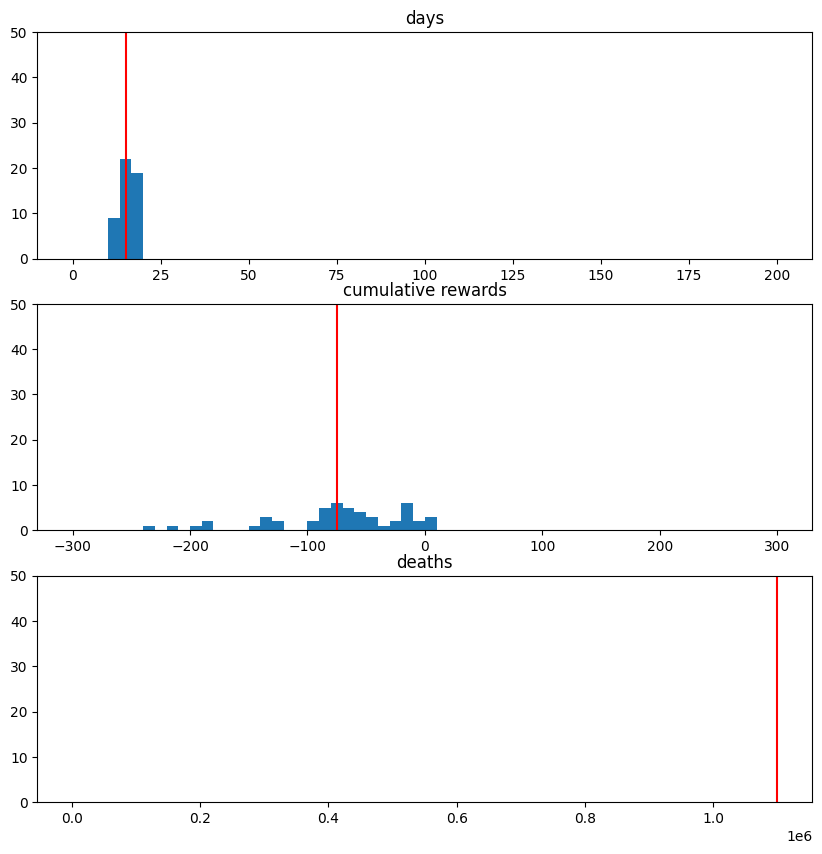

In [10]:
agent_russo = RussoAgent(env)

def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards':
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
def run_experiment(agent, num_episodes):
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    rewards = []
    confine = []
    death = []
    for trace in range(num_episodes):
        log = []
        seed = trace
        finished = False
        obs, info = env.reset(seed)
        agent.reset()
        n_weeks_confined = 0
        R_sum = 0
        while not finished:
            action = agent.act(obs)
            obs, R, finished, info = env.step(action)
            log.append(info) # save the information dict for logging
            R_sum += R[0][0]
            if action == 1:
                n_weeks_confined += 1
            if finished:
                break
        """ Parse the logs """
        total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
        confine.append(n_weeks_confined) 
        rewards.append(R_sum)
        death.append(np.sum(total['dead']))
    hist_avg(ax[0], confine, "days")
    hist_avg(ax[1],rewards, "cumulative rewards")
    hist_avg(ax[2], death, "deaths")
run_experiment(agent_russo, 50)

### Question 3.a) implementing Deep Q-Learning

In [12]:
from itertools import count
from DQ_learning.model import DQN
from DQ_learning.agent import Agent, ReplayMemory, DQNAgent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.pow(torch.Tensor(np.stack((infected, dead))).unsqueeze(0), 1/4)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

n_episodes = 500
LR = 5 * 10**(-3)
GAMMA = 0.9
buffer_size = 20000
BATCH_SIZE = 2048

In [13]:
agent = DQNAgent(env, DQN)
log_eval = []
log_train = []
for i_episode in range(1, 501):
    print(i_episode)
    R_total = 0
    state, info = env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    update_target = False
    if i_episode%5 ==0:
        update_target = True
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env.step(action.item())
        R_total += reward[0][0]
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)
        # Move to the next state
        state = next_state
        # Perform one step of the optimization (on the policy network)
        agent.optimize_model(update_target)
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = agent.target_net.state_dict()
        policy_net_state_dict = agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
        agent.target_net.load_state_dict(target_net_state_dict)
    log_train.append(R_total)
    if i_episode%50 == 0:
        R_total = []
        agent.epsilon = 0
        for i in range(20):
            state, info = env.reset(seed = 1)
            state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
            for t in count():
                action = agent.act(state, i_episode)
                observation, reward, terminated, truncated = env.step(action.item())
                R_total.append(reward[0][0])
                reward = torch.tensor([reward], device=device)
                done = terminated or truncated
                if terminated:
                    next_state = None
                    break
                else:
                    next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                state = next_state
        agent.epsilon = 0.7
        log_eval.append(np.mean(R_total))

1


<ipython-input-13-18cb586579e0>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
<ipython-input-13-18cb586579e0>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


<ipython-input-13-18cb586579e0>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
<ipython-input-13-18cb586579e0>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)


51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
3

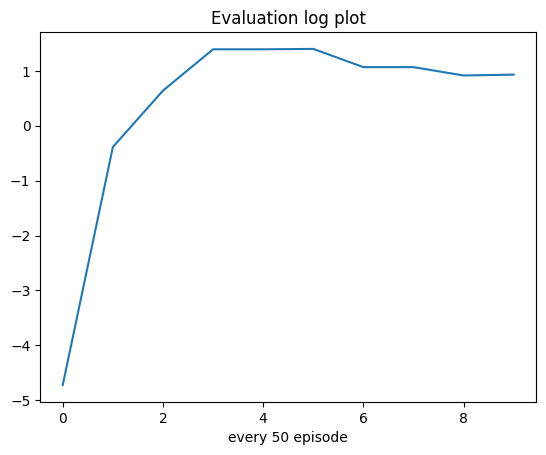

[-4.721887, -0.38729528, 0.6407575, 1.3936889, 1.3936889, 1.4005424, 1.0686171, 1.0686171, 0.91622806, 0.9323712]


In [14]:
plt.plot(log_eval)
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(log_eval)

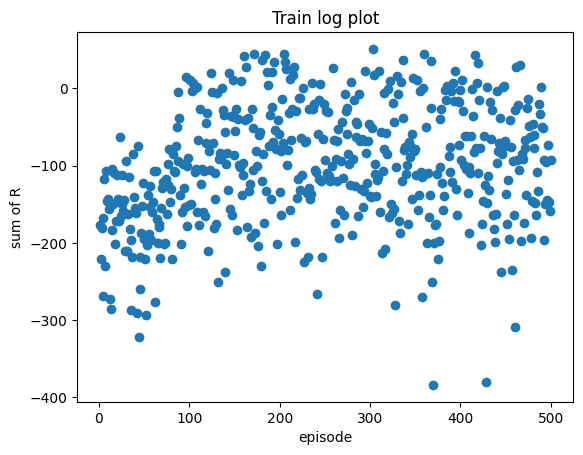

In [15]:
plt.scatter(y = log_train, x = np.arange(1, 501))
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

In [16]:
agent = DQNAgent(env, DQN)
log_eval = []
log_train = []
decreasing = True
for i_episode in range(1, 501):
    print(i_episode)
    R_total = 0
    state, info = env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    update_target = False
    if i_episode%5 ==0:
        update_target = True
    for t in count():
        action = agent.act(state, i_episode, decreasing)
        observation, reward, terminated, truncated = env.step(action.item())
        R_total += reward[0][0]
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)
        # Move to the next state
        state = next_state
        # Perform one step of the optimization (on the policy network)
        agent.optimize_model(update_target)
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = agent.target_net.state_dict()
        policy_net_state_dict = agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
        agent.target_net.load_state_dict(target_net_state_dict)
    log_train.append(R_total)
    if i_episode%50 == 0:
        R_total = []
        agent.epsilon = 0
        for i in range(20):
            state, info = env.reset(seed = 1)
            state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
            for t in count():
                action = agent.act(state, i_episode, decreasing)
                observation, reward, terminated, truncated = env.step(action.item())
                R_total.append(reward[0][0])
                reward = torch.tensor([reward], device=device)
                done = terminated or truncated
                if terminated:
                    next_state = None
                    break
                else:
                    next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                state = next_state
        agent.epsilon = 0.7
        log_eval.append(np.mean(R_total))

1


<ipython-input-16-8e136c44c9ef>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
<ipython-input-16-8e136c44c9ef>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


<ipython-input-16-8e136c44c9ef>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
<ipython-input-16-8e136c44c9ef>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)


51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
3

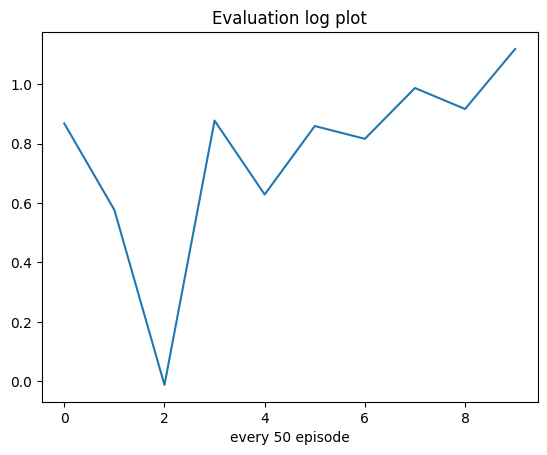

[0.86747783, 0.5766968, -0.0122999, 0.87721884, 0.62836343, 0.85895306, 0.81584895, 0.9868583, 0.9161574, 1.1184151]


In [17]:
plt.plot(log_eval)
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(log_eval)

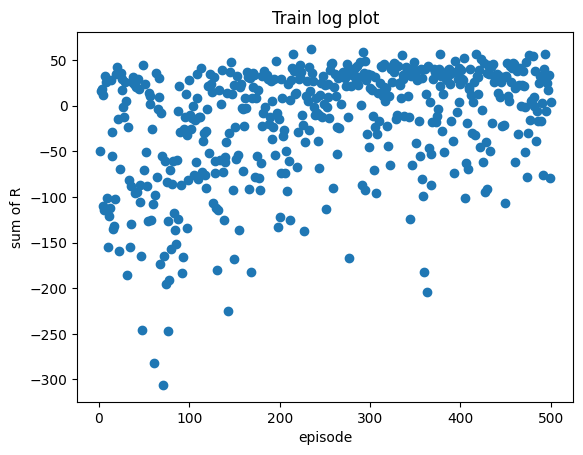

In [18]:
plt.scatter(y = log_train, x = np.arange(1, 501))
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

### Question 4.1.a) (Theory) Action space design

### Question 4.1.b) Toggle-action-space multi-action policy training

In [19]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(3, dyn.n_cities, dyn.env_step_length), # + current state 
                                    dtype=np.float16)

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action_toggle = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

    if a == ACTION_CONFINE:
        action_toggle['confinement'] = not action_toggle['confinement']
    elif a == ACTION_ISOLATE:
        action_toggle['isolation'] = not action_toggle['isolation']
    elif a == ACTION_VACCINATE:
        action_toggle['vaccinate'] = not action_toggle['vaccinate']
    elif a == ACTION_HOSPITAL:
        action_toggle['hospital'] = not action_toggle['hospital']
    
    return action_toggle

# def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
#     infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
#     dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
#     confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
#     return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    obs_ = np.concatenate((
        np.ones((1, 7)) * int((dyn.get_action()['confinement'])),
        np.ones((1, 7)) * int((dyn.get_action()['isolation'])),
        np.ones((1, 7)) * int((dyn.get_action()['vaccinate'])),
        np.ones((1, 7)) * int((dyn.get_action()['hospital'])), 
        np.zeros((5, 7))
    )) 
    return torch.pow(torch.Tensor(np.stack((infected, dead, obs_))).unsqueeze(0), 1/4)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [20]:
agent = DQNAgent(env, DQN, lr = 1e-5)
log_eval = []
log_train = []
for i_episode in range(1, 501):
    print(i_episode)
    R_total = 0
    state, info = env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    update_target = False
    if i_episode%5 ==0:
        update_target = True
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env.step(action.item())
        R_total += reward[0][0]
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)
        # Move to the next state
        state = next_state
        # Perform one step of the optimization (on the policy network)
        agent.optimize_model(update_target)
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = agent.target_net.state_dict()
        policy_net_state_dict = agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
        agent.target_net.load_state_dict(target_net_state_dict)
    log_train.append(R_total)
    if i_episode%50 == 0:
        R_total = []
        rewards = 0
        agent.epsilon = 0
        for i in range(20):
            state, info = env.reset(seed = 1)
            state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
            for t in count():
                action = agent.act(state, i_episode)
                observation, reward, terminated, truncated = env.step(action.item())
                R_total.append(reward[0][0])
                reward = torch.tensor([reward], device=device)
                done = terminated or truncated
                if terminated:
                    next_state = None
                    break
                else:
                    next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                state = next_state
        if np.mean(R_total) >= rewards:
            rewards = np.mean(R_total)
            agent.save_model("/content/DQ_learning/models/4_1_b.pt")
        agent.epsilon = 0.7
        log_eval.append(np.mean(R_total))

1


<ipython-input-20-051432b5c7a9>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
<ipython-input-20-051432b5c7a9>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


<ipython-input-20-051432b5c7a9>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
<ipython-input-20-051432b5c7a9>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)


51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
3

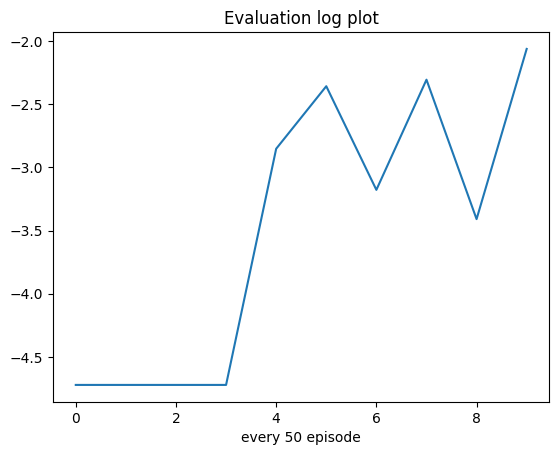

[-4.721887, -4.721887, -4.721887, -4.721887, -2.8527486, -2.3577054, -3.1780725, -2.306038, -3.4096005, -2.0625346]


In [21]:
plt.plot(log_eval)
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(log_eval)

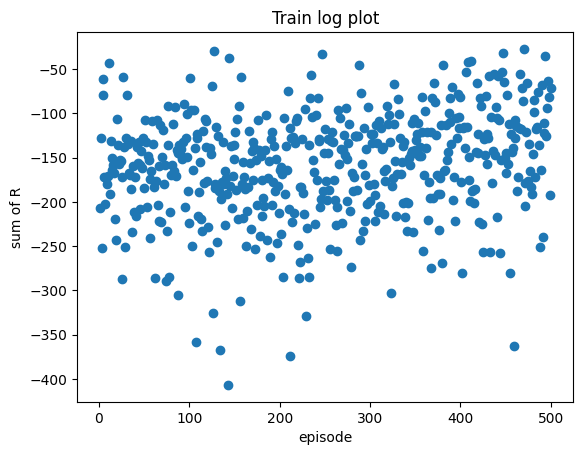

In [22]:
plt.scatter(y = log_train, x = np.arange(1, 501))
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

In [23]:
agent.load_model("/content/DQ_learning/models/4_1_b.pt")
log_eval = []
for i_episode in range(1, 4):
    print(i_episode)
    state, info = env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    R_total = []
    agent.epsilon = 0
    state, info = env.reset()
    state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env.step(action.item())
        R_total.append(reward[0][0])
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    log_eval.append(np.mean(R_total))

1


<ipython-input-23-451330e95c92>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
<ipython-input-23-451330e95c92>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
<ipython-input-23-451330e95c92>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)


2
3


In [ ]:
log_eval

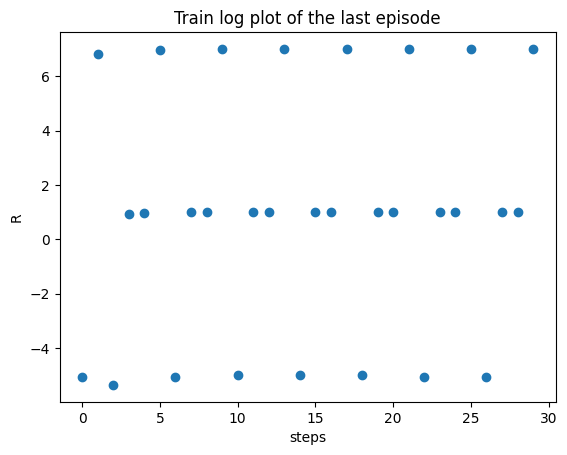

In [24]:
plt.scatter(x = np.arange(len(R_total)), y = R_total)
plt.title("Train log plot of the last episode")
plt.xlabel("steps")
plt.ylabel("R")
plt.show();

### Question 4.1.c) Toggle-action-space multi-action policy evaluation

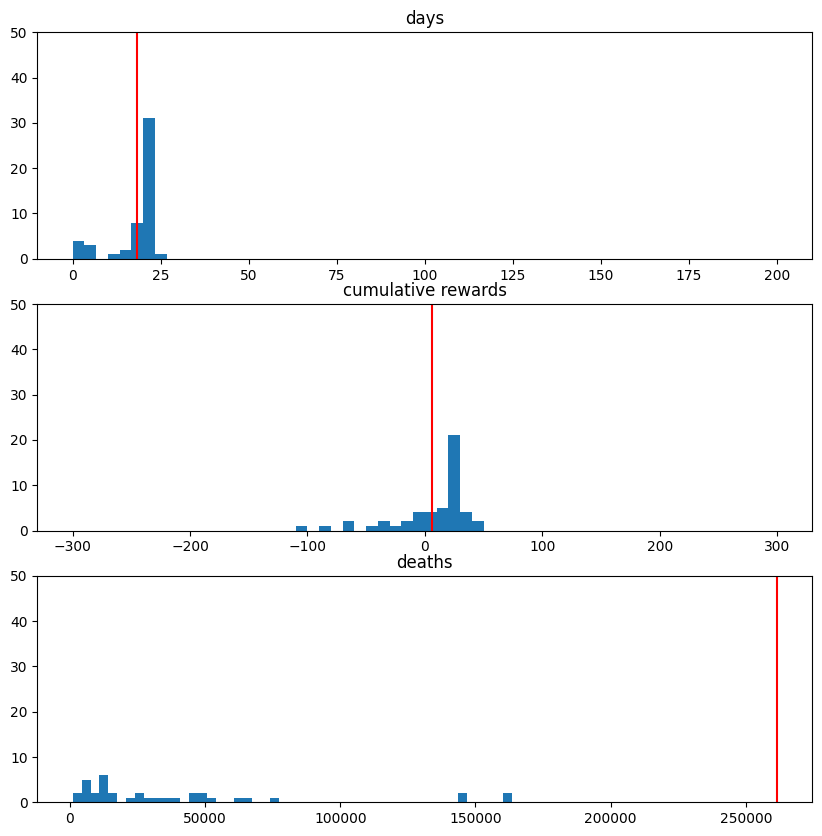

In [25]:
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards':
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
def run_experiment(agent, num_episodes):
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    rewards = []
    confine = []
    death = []
    for trace in range(num_episodes):
        log = []
        seed = trace
        finished = False
        obs, info = env.reset(seed)
        # agent.reset()
        n_weeks_confined = 0
        R_sum = 0
        while not finished:
            action = agent.act(obs.flatten().unsqueeze(0), i_episode)
            obs, R, finished, info = env.step(action)
            log.append(info) # save the information dict for logging
            R_sum += R[0][0]
            if action == 1:
                n_weeks_confined += 1
            if finished:
                break
        """ Parse the logs """
        total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
        confine.append(n_weeks_confined) 
        rewards.append(R_sum)
        death.append(np.sum(total['dead']))
    hist_avg(ax[0], confine, "days")
    hist_avg(ax[1],rewards, "cumulative rewards")
    hist_avg(ax[2],death, "deaths")
    
run_experiment(agent, 50)

### Question 4.2.a) multi-action factorized Q-values policy training